# Finding the parameters of Lotka-Volterra equations with Evolution Strategies

The Lotka-Volterra equations, named after Alfred Lotka and Vito Volterra, are a mathematical model for understanding how the populations of predator and prey species can influence each other's growth and evolution over time. The equations consist of two coupled first-order differential equations, one for the predator population ($Y$) and one for the prey population ($X$):

$$  \frac{dX}{dt} = rX - aXY $$

$$  \frac{dY}{dt} = bXY -zY $$

Equations are defined by a set of parameters, such as $r$, $a$, $z$, and $b$, in the previous formulation.

The goal of this lab session is to find the parameters of a dynamic system defined by Lotka-Volterra equations leveraging **Evolution Strategies** (ES). We will consider having access to the trajectories corresponding to a single simulation.

First of all, let us import some useful modules and functions.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint #solver for a system of ordinary differential equations

random.seed(0)
np.random.seed(0)

Now, we want to write the code to actually perform the simulation and get our trajectories.  Let's define a function that, given the current state, the time instant, and the parameters, returns the derivatives calculated by the Lotka-Volterra equations. We don't know who is the prey and the predator a priori, the sign is given by the parameter itself!

In [6]:
# Define the Lotka-Volterra equations
def lotka_volterra(state, t, params):
    x, y = state
    dxdt = params[0,0] * x - params[0,1] * x * y
    dydt = params[1,0] * x * y - params[1,1] * y
    return [dxdt, dydt]

Now we arbitrarily choose the initial conditions of our simulation, a set of parameters and the time vector.

In [7]:
# Set the initial conditions and parameters
initial_conditions = [30, 10]  # Initial populations of species X and Y

real_params = np.array(
    [[0.1, 0.02],
    [0.01, 0.1]],
)

# Create a time vector
t = np.linspace(0, 100, 1000)

# Solve the differential equations using odeint
solution = odeint(lotka_volterra, initial_conditions, t, args=(real_params,))

# Extract the populations of each species
x, y = solution.T

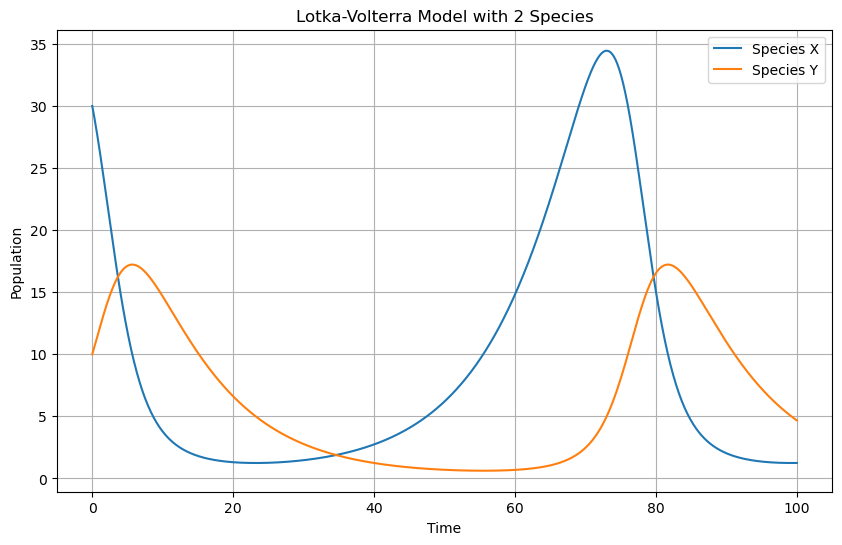

In [8]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Species X')
plt.plot(t, y, label='Species Y')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Model with 2 Species')
plt.grid(True)
plt.show()

Now, let's assume we don't know the parameters that generated the previous trajectories. We aim to find them using ES!

Define a fitness function which suits the problem. Each individual is a set of parameters for the Lotka-Volterra equations and we want to get as close as possible to the actual one through the evolution.

In [9]:
# Fitness function
class MSE_fit():
    
    def __init__(self, target_traj):
        self.target_traj = target_traj

    def eval(self, individual):
        t = np.linspace(0, 100, 1000)
        initial_conditions=self.target_traj[0]
        sol = odeint(lotka_volterra, initial_conditions, t, args=(individual,))
        return np.mean((sol - self.target_traj) ** 2)

Define a class for our ES. It must implement the One-Fifth Rule for variance self-adaptation. Implement a strategy of your choice for recombination.

In [10]:
def intermediate_recombination(parents):
    child = np.mean(parents, axis=0)
    return child

In [11]:
def discrete_recombination(parents):
    child = np.zeros(parents[0].shape)
    for i in range(child.shape[0]):
        for j in range(child.shape[1]):
            selected_parent = parents[np.random.choice(len(parents))]
            child[i,j] = selected_parent[i,j]
    return child

In [12]:
class EvolutionStrategy(object):
    
    def __init__(self, mu, lmb, ro, fit, rec, individual_shape, limits, plus=False, initial_variance=1, k=10, c=0.5):
        self.mu = mu
        self.lmb = lmb
        self.ro = ro
        self.plus = plus
        self.fit = fit
        self.rec = rec #recombination strategy
        self.individual_shape = individual_shape
        self.limits = limits
        self.pop = []
        self.variance = initial_variance
        self.k = k
        self.c = c
        self.k_counter = 0
        # Initialize the population
        lower, upper = self.limits
        for _ in range(self.lmb):
            individual = np.zeros(self.individual_shape)
            for i in range(self.individual_shape[0]):
                for j in range(self.individual_shape[1]):
                    individual[i,j] = random.uniform(lower, upper)
            self.pop.append(individual)
        self.best = min(self.pop, key=self.fit)
        self.best_fit=self.fit(self.best)
    
    def generation(self):
        self.k_counter += 1 # when equal to k, we update the variance
        self.truncated_selection()
        new_pop = []
        fitter_off = 0
        for i in range(0, self.lmb):
            parents = random.sample(self.pop, self.ro)
            child = self.rec(parents)
            new_ind = self.mutation(child)
            new_pop.append(new_ind)
            # check to avoid useless calculations of the fitness function
            if self.k_counter == self.k:
                if self.fit(new_ind)<self.fit(child):
                    fitter_off += 1
        if self.k_counter == self.k:
            self.k_counter = 0
            if fitter_off/self.lmb < 1/5:
                self.variance = self.c*self.variance
            else:
                self.variance = self.variance/self.c
        if self.plus:
            self.pop = self.pop + new_pop
        else:
            self.pop = new_pop
        candidate_best = min(self.pop, key=self.fit)
        if self.fit(self.best) > self.fit(candidate_best):
            self.best = candidate_best
            self.best_fit = self.fit(self.best)
    
    def mutation(self, individual):
        new_ind = np.zeros(individual.shape)
        for i in range(individual.shape[0]):
            for j in range(individual.shape[1]):
                param = individual[i,j]
                tmp = param + random.gauss(0, self.variance)
                if tmp < self.limits[0]:
                    tmp = self.limits[0]
                if tmp > self.limits[1]:
                    tmp = self.limits[1]
                new_ind[i,j] = tmp
        return new_ind
    
    def truncated_selection(self):
        list.sort(self.pop, key=self.fit)
        self.pop = self.pop[0:self.mu]
        
    def __str__(self):
        s = f"Best individual: {self.best}\n"
        s += f"with fitness {self.fit(self.best)}"
        return s

Run the evolution and save the best fitness score for each generation.

In [13]:
mse = MSE_fit(target_traj=solution).eval

ES = EvolutionStrategy(50, 100, 2, mse, discrete_recombination, (2, 2), [-0.2, 0.2], k=20, plus=True)
history = [ES.best_fit]
n_gen = 300
for i in range(0, n_gen):
    ES.generation()
    history.append(ES.best_fit)

/home/lollo/miniconda3/envs/optai/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1431748067284D+02   r2 =  0.7697524093083D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1431748067284D+02   r2 =  0.7697524093083D-15


Plot and visualize the results

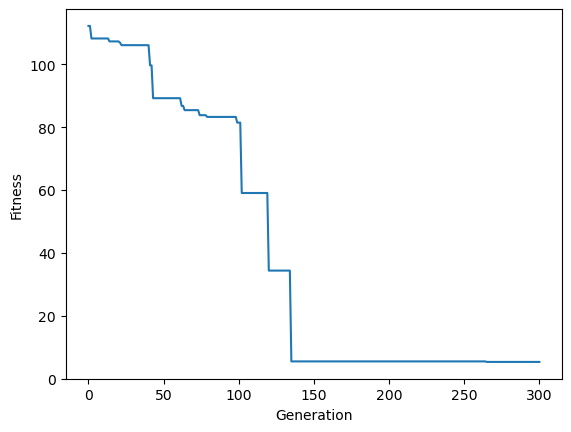

In [14]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.show()

In [15]:
res_best = odeint(lotka_volterra, initial_conditions, t, args=(ES.best,))

# Extract the populations of each species
x, y = res_best.T

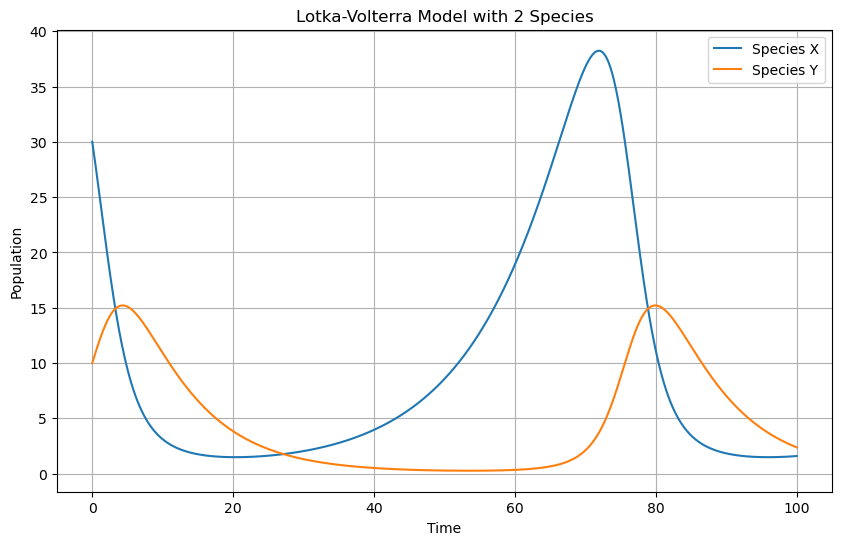

In [16]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Species X')
plt.plot(t, y, label='Species Y')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Model with 2 Species')
plt.grid(True)
plt.show()

In [17]:
print(ES)

Best individual: [[0.08572462 0.02321804]
 [0.01112042 0.12591994]]
with fitness 5.31916168391208
